In [1]:
# model segformerb4 settings
from mmseg.models import build_segmentor
from mmcv.runner.optimizer import build_optimizer
import torch

def segformer():
    model = dict(
        type='SunSegmentor',
        backbone=dict(
            type='MixVisionTransformer',
            in_channels=3,
            embed_dims=64,
            num_stages=4,
            num_layers=[2,2,2,2],
            num_heads=[1, 2, 5, 8],
            patch_sizes=[7, 3, 3, 3],
            sr_ratios=[8, 4, 2, 1],
            out_indices=(0, 1, 2, 3),
            mlp_ratio=4,
            qkv_bias=True,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            drop_path_rate=0.1,
            pretrained=None),
        decode_head=dict(
            type='DRPHead',
            in_channels=[64, 128, 320, 512],
            in_index=[0, 1, 2, 3],
            channels=128,
            dropout_ratio=0.1,
            num_classes=1,
            norm_cfg=dict(type='BN', requires_grad=True),
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    model = build_segmentor(model)
    model.init_weights()
    return model
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
model = segformer()

model(torch.rand((2,3,128,128))).shape

/home/nguyen.van.quan/miniconda3/envs/mmseg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nguyen.van.quan/Polyp/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2023-01-03 07:37:05,373 - mmcv - INFO - initialize DRPHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2023-01-03 07:37:05,386 - mmcv - INFO - 
backbone.layers.0.0.projection.weight - torch.Size([64, 3, 7, 7]): 
Initialized by user-defined `init_weights` in MixVisionTransformer  
 
2023-01-03 07:37:05,390 - mmcv - INFO - 
backbone.layers.0.0.projection.bias - torch.Size([

torch.Size([2, 1, 128, 128])

In [2]:
count_parameters(model)

54.52123

In [2]:
from mmcv.cnn import get_model_complexity_info

def get_model_info(model, tsize):
    model.eval()

    input_shape = (3, tsize[0], tsize[1])
    flops, params = get_model_complexity_info(model, input_shape)
    split_line = '=' * 30
    print('{0}\nInput shape: {1}\nFlops: {2}\nParams: {3}\n{0}'.format(
        split_line, input_shape, flops, params))
    print('!!!Please be cautious if you use the results in papers. '
          'You may need to check if all ops are supported and verify that the '
          'flops computation is correct.')
    

get_model_info(model, (352, 352))

SunSegmentor(
  52.719 M, 94.466% Params, 11.847 GFLOPs, 100.000% FLOPs, 
  (backbone): MixVisionTransformer(
    10.063 M, 18.032% Params, 3.213 GFLOPs, 27.123% FLOPs, 
    (layers): ModuleList(
      10.063 M, 18.032% Params, 3.213 GFLOPs, 27.123% FLOPs, 
      (0): ModuleList(
        0.606 M, 1.086% Params, 0.695 GFLOPs, 5.866% FLOPs, 
        (0): PatchEmbed(
          0.01 M, 0.017% Params, 0.074 GFLOPs, 0.628% FLOPs, 
          (projection): Conv2d(0.009 M, 0.017% Params, 0.073 GFLOPs, 0.619% FLOPs, 3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (norm): LayerNorm(0.0 M, 0.000% Params, 0.001 GFLOPs, 0.008% FLOPs, (64,), eps=1e-06, elementwise_affine=True)
        )
        (1): ModuleList(
          0.596 M, 1.069% Params, 0.62 GFLOPs, 5.230% FLOPs, 
          (0): TransformerEncoderLayer(
            0.298 M, 0.534% Params, 0.31 GFLOPs, 2.615% FLOPs, 
            (norm1): LayerNorm(0.0 M, 0.000% Params, 0.001 GFLOPs, 0.008% FLOPs, (64,), eps=1e-06, elementwi

In [ ]:

from mmseg.models.decode_heads.lib.bifpn import *

bifpn = BiFPN([64, 128, 320, 512], 128)

test1 = torch.rand((2, 64, 128, 128))
test2 = torch.rand((2, 128, 64, 64))
test3 = torch.rand((2, 320, 32, 32))
test4 = torch.rand((2, 512, 16, 16))

bifpn_out = bifpn([test1, test2, test3, test4])
for i in bifpn_out:
    print(i.shape)


In [ ]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
from mcode.custom_transform import *
import glob

val_transform = A.Compose([
    DilationAndErosion(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
import torchvision.transforms as transforms
from mcode.custom_transform import *
import glob
train_transform = transforms.Compose([
    Random_flip(),
    Random_image_enhance(),
    Random_rotate(),
    Random_scale_crop(),
    Tonumpy(),
    Normalize(),
    Totensor(),
    
])

In [ ]:
from torch.utils.data import Dataset, DataLoader

f_images = glob.glob('TrainDataset/image/*')
f_masks = glob.glob('TrainDataset/mask/*')

X_test = glob.glob('TestDataset/*/images/*')
y_test = glob.glob('TestDataset/*/masks/*')

# X_val = glob.glob('/content/TestDataset/ETIS-LaribPolypDB/images/*')
# y_val = glob.glob('/content/TestDataset/ETIS-LaribPolypDB/masks/*')

trainsize = 352

budget_size = 75

seed = 2022

device = 'cuda:0'
class ActiveDataset(Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_paths=[], gt_paths=[], trainsize=352, transform=None):
        self.trainsize = trainsize
        self.images = image_paths
        self.masks = gt_paths
        self.size = len(self.images)
        self.filter_files()
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.rgb_loader(self.images[index])
        mask = self.binary_loader(self.masks[index])
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        sample = dict(image=image, mask=mask.unsqueeze(0), image_path=self.images[index], mask_path=self.masks[index])
        
        return sample

    def filter_files(self):
        assert len(self.images) == len(self.masks)
        images = []
        masks = []
        for img_path, mask_path in zip(self.images, self.masks):
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            if img.size == mask.size:
                images.append(img_path)
                masks.append(mask_path)
        self.images = images
        self.masks = masks
    
    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f).resize((trainsize, trainsize), Image.BILINEAR)
            return np.array(img.convert('RGB'))

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f).resize((trainsize, trainsize), Image.NEAREST)
            img = np.array(img.convert('L'))
            return img

    def __len__(self):
        return self.size

In [ ]:


train_dataset = ActiveDataset(
    f_images, 
    f_masks, 
    trainsize=trainsize, 
    transform=val_transform
)


print(f"Train size: {len(train_dataset)}")




In [ ]:
sample = train_dataset[10]

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
# lets look at some samples
from matplotlib import pyplot as plt
sample = train_dataset[10]


plt.subplot(1,2,1)
plt.imshow(unorm(sample["image"]).permute(1, 2, 0)) # for visualization we have to permute back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [ ]:
import torch

a = torch.randint(0, 100, (1780,))

a = a[::, None]
print(a.shape)

b = torch.tensor([10, 20])
c = torch.tensor([5, 6])

a[b] = c

print(a[10], a[20])
print(a.shape, b.shape, c.shape)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
class ScaleBranch(nn.Module):

    def __init__(self, in_channels=256, out_channels=256):
        super(ScaleBranch, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.spatialPooling = nn.AdaptiveAvgPool3d((2, 1, 1))
        self.scalePooling = nn.AdaptiveAvgPool2d(1)
        self.channel_agg = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.trans = nn.Conv2d(self.in_channels, 1, 1)

    def forward(self, x):
        x = self.spatialPooling(x.permute(0, 2, 1, 3, 4)).reshape(
            x.size(0), x.size(2), 2, 1)
        print(x.shape)
        batch, channel, height, width = x.size() # B, C, 2, 1
        channel_context = self.channel_agg(x)
        print(channel_context.shape)
        channel_context = channel_context.view(batch, 1, height * width)
        print(channel_context.shape)
        channel_context = F.softmax(channel_context, dim=-1)
        channel_context = channel_context * height * width
        channel_context = channel_context.view(batch, 1, height, width)
        res = x * channel_context
        print(res.shape)
        context = self.scalePooling(x * channel_context)

        context = self.trans(context)
        return context
    

model = ScaleBranch()
a = torch.rand((10, 2, 256, 128, 128))
model(a).shape

In [6]:
from torch.nn import functional as F
import torch
import cv2
img = cv2.imread('/home/nguyen.van.quan/scatsimclr/TestDataset/CVC-300/images/149.png')
x = cv2.resize(img[:,:,::-1], (352, 352))
x = torch.from_numpy(x).unsqueeze(0).float().permute(0,3,1,2)

rgb_down2 = F.interpolate(x, scale_factor = 0.5, mode='bilinear')
rgb_down4 = F.interpolate(rgb_down2, scale_factor = 0.5, mode='bilinear')
rgb_down8 = F.interpolate(rgb_down4, scale_factor = 0.5, mode='bilinear')
rgb_down16 = F.interpolate(rgb_down8, scale_factor = 0.5, mode='bilinear')
rgb_down32 = F.interpolate(rgb_down16, scale_factor = 0.5, mode='bilinear')
rgb_up16 = F.interpolate(rgb_down32, rgb_down16.shape[2:], mode='bilinear')
rgb_up8 = F.interpolate(rgb_down16, rgb_down8.shape[2:], mode='bilinear')
rgb_up4 = F.interpolate(rgb_down8, rgb_down4.shape[2:], mode='bilinear')
rgb_up2 = F.interpolate(rgb_down4, rgb_down2.shape[2:], mode='bilinear')
rgb_up = F.interpolate(rgb_down2, x.shape[2:], mode='bilinear')

lap1 = x - rgb_up
lap2 = rgb_down2 - rgb_up2
lap3 = rgb_down4 - rgb_up4
lap4 = rgb_down8 - rgb_up8
lap5 = rgb_down16 - rgb_up16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


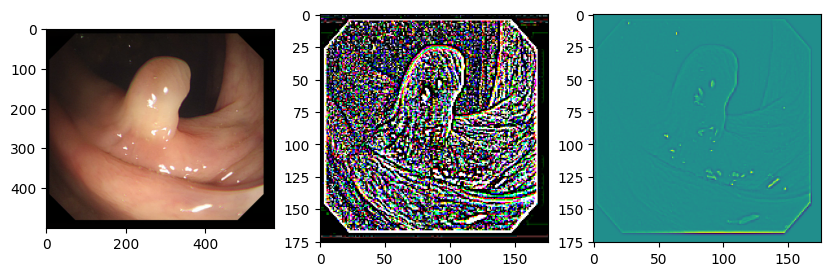

In [8]:
from matplotlib import pyplot as plt
import numpy as np
lap1 = lap2.squeeze().permute(1,2,0).numpy()

f, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].imshow(img[:,:,::-1])
ax[1].imshow(lap1)
ax[2].imshow(np.mean(lap1, axis=-1))
